# Hardware demo of the Fast&Deep framework
This is executed live on the BrainScaleS-2 system
For details, see [the code on GitHub](https://github.com/JulianGoeltz/fastanddeep) or [the paper on arXiv](https://arxiv.org/abs/1912.11443) or [Nature Machine Intelligence](https://www.nature.com/articles/s42256-021-00388-x)

In [1]:
#!python3
import datetime
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from pprint import pprint
import sys
import time
import torch
import yaml

import training
import datasets
import evaluation
import utils

%matplotlib inline

## Defining which pretrained file should be used

In [2]:
base_dirname = "../experiment_pretrained/16x16_mnist_hx_chip55/"

config_path = osp.join(base_dirname, "config.yaml")
start_epoch = 100
detailed_timing = False

os.environ['QUIGGELDY_USER_NO_MUNGE'] = os.environ['JUPYTERHUB_USER']
os.environ['QUIGGELDY_ENABLED'] = '1'
os.environ['QUIGGELDY_IP'] = '10.0.2.2'  # because on VM, otherwise 10.2.17.58
os.environ['QUIGGELDY_PORT'] = '10360'
os.environ['SLURM_HARDWARE_LICENSES'] = 'chip55_port10360_capocaccia'  # hard coded chip setup, used internally

## Loading data, defining shorthands


In [3]:
# there can only be one hardware connection. if net has been initialised, the connection needs to be shut down first
if 'net' in vars():
    del(net)
    
dataset, neuron_params, network_layout, training_params = training.load_config(config_path)

if dataset == "yin_yang":
    multiply_input_layer = 1 if not training_params['use_hicannx'] else 5
    multiply_bias = 1 if not training_params['use_hicannx'] else 5
    dataset_train = datasets.YinYangDataset(size=5000, seed=42, multiply_input_layer=multiply_input_layer)
    dataset_val = datasets.YinYangDataset(size=1000, seed=41, multiply_input_layer=multiply_input_layer)
    dataset_test = datasets.YinYangDataset(size=1000, seed=40, multiply_input_layer=multiply_input_layer)
elif dataset == "mnist":
    dataset_train = datasets.FullMnist('train')
    dataset_val = datasets.FullMnist('val')
    dataset_test = datasets.FullMnist('test')
elif dataset == "16x16_mnist":
    width_pixel = network_layout.get('width_pixel', 16)
    if width_pixel != 16:
        print("*********************************************")
        print(f"using mnist reduced to {width_pixel}x{width_pixel}, not usual 16x16")
        print("*********************************************")
        network_layout['n_inputs'] = width_pixel**2
    dataset_train = datasets.HicannMnist('train', late_at_inf=True, width_pixel=width_pixel)
    dataset_val = datasets.HicannMnist('val', late_at_inf=True, width_pixel=width_pixel)
    dataset_test = datasets.HicannMnist('test', late_at_inf=True, width_pixel=width_pixel)
else:
    sys.exit("data set given in parameter file is unknown")
filename = dataset

savepoints = [start_epoch, ]

t_start = time.time()
net = training.continue_training(base_dirname, filename, start_epoch, savepoints,
                                 dataset_train, dataset_val, dataset_test)
t_end = time.time()
duration = t_end - t_start
print('Training {0} epochs -> duration: {1} seconds'.format(
    savepoints[-1] - start_epoch, duration))

dirname = base_dirname + f"/epoch_{savepoints[-1]}/"
device = utils.get_default_device()
untrained = False

def fasteval_loads(dirname, filename):
    dataset, neuron_params, network_layout, training_params = training.load_config(dirname + "/config.yaml")
    training_params['batch_size_eval'] = 10000
    loader = utils.DeviceDataLoader(torch.utils.data.DataLoader(
        dataset_test, batch_size=training_params.get('batch_size_eval', None), shuffle=False), device)
    for i, data in enumerate(loader):
        inputs, labels = data
    return inputs, labels

def fasteval_doit(inputs, labels, net):
    with torch.no_grad():
        if detailed_timing:
            start = time.time()
        outputs, hiddens = net(inputs)
        if detailed_timing:
            print(f"net took {time.time() - start}")
    firsts = outputs.argmin(1)
    firsts_reshaped = firsts.view(-1, 1)
    nan_mask = torch.isnan(torch.gather(outputs, 1, firsts_reshaped)).flatten()
    inf_mask = torch.isinf(torch.gather(outputs, 1, firsts_reshaped)).flatten()
    firsts[nan_mask] = -1
    firsts[inf_mask] = -1
    wrongs = torch.logical_not(torch.eq(labels.to(device), firsts)).detach().cpu().numpy()
    acc = (len(outputs) - wrongs.sum()) / len(outputs)
    # print(f"### test accuracy {acc}")
    return acc

def classify(dirname='tmp', show=False, device=None, net=None,
             datasets_list=[
                 ['test', dataset_test],
                 # ['train', dataset_train],
             ]):
    """eases re-evaluation with alive net on hx"""
    # neuron_params, training_params, network_layout = load_config(dirname, filename)
    for datatype, dataset in datasets_list:
        outputs, labels, _, inputs = evaluation.run_inference(dirname, filename, dataset, False, False, device,
                                                              return_all=True, net=net)
        firsts = outputs.argmin(1)
        firsts_reshaped = firsts.view(-1, 1)
        nan_mask = torch.isnan(torch.gather(outputs, 1, firsts_reshaped)).flatten()
        inf_mask = torch.isinf(torch.gather(outputs, 1, firsts_reshaped)).flatten()
        firsts[nan_mask] = -1
        firsts[inf_mask] = -1
        wrongs = torch.logical_not(torch.eq(torch.tensor(labels).to(device), firsts)).detach().cpu().numpy()
        acc = (len(outputs) - wrongs.sum()) / len(outputs)
        print(f"{datatype} accuracy {acc}")
    if len(datasets_list) == 1:
        return acc


load preprocessed data
load preprocessed data
load preprocessed data
Using CPU, Meh!
training_params
{'alpha': 0.005, 'batch_size': 200, 'batch_size_eval': 1000, 'beta': 1.0, 'enforce_cpu': False, 'epoch_number': 200, 'epoch_snapshots': [1, 30, 50, 100, 150, 200], 'learning_rate': 0.003, 'lr_scheduler': {'gamma': 0.9, 'step_size': 10, 'type': 'StepLR'}, 'max_dw_norm': 0.2, 'max_num_missing_spikes': [0.5, 0.5], 'momentum': 0, 'numpy_seed': 12345, 'optimizer': 'adam', 'print_step_percent': 5.0, 'resolution': 0.01, 'sim_time': 3.0, 'torch_seed': 420420, 'training_noise': {'mean': 0.0, 'std_dev': 0.3}, 'use_forward_integrator': False, 'use_hicannx': True, 'weight_bumping_exp': True, 'weight_bumping_targeted': True, 'weight_bumping_value': 0.005, 'xi': 0.2}
network_layout
{'bias_times': [], 'layer_sizes': [246, 10], 'n_biases': [0, 0], 'n_inputs': 256, 'n_layers': 2, 'weight_means': [0.01, 0.006], 'weight_stdevs': [0.03, 0.1]}
Saving snapshots at epochs [200]
loading data
loading network
^^

## First execution
Numba compiles the function there

In [4]:
inputs, labels = fasteval_loads(dirname, filename)
net.fast_eval = True
net.hx_settings['single_simtime'] = 12.  # change this
acc = fasteval_doit(inputs, labels, net)
print(f"initial accuracy {acc}")

initial accuracy 0.9713


## Looping over a few classifications to get statistics

In [5]:
net.hx_settings['single_simtime'] = 7.
net.hx_record_neuron = None  # make sure that there is no recording done

print("starting loop")
accs, walls = [], []
for i in range(5):
    start = time.time()
    acc = fasteval_doit(inputs, labels, net)
    end = time.time()
    print(f"       current acc {acc:.3f} current wall {end-start:.3f}")
    accs.append(acc)
    walls.append(end - start)
print(f"accs {np.mean(accs):.3f}+-{np.std(accs):.3f}  median {np.median(accs):.3f}\n"
      f"walls {np.mean(walls):.3f}+-{np.std(walls):.3f} median {np.median(walls):.3f}")
# print(accs)
# print([f"{wall:.3f}" for wall in walls])


starting loop
       current acc 0.971 current wall 1.104
       current acc 0.970 current wall 1.096
       current acc 0.971 current wall 1.109
       current acc 0.971 current wall 1.055
       current acc 0.970 current wall 1.086
accs 0.971+-0.000  median 0.971
walls 1.090+-0.019 median 1.096


## plotting

In [6]:
# which digit should be used
n_instance = 0
single_sim_time = 10
time_shown = (0, 20)
n_repetitions = 2


filename = '16x16_mnist'
n_classes = 10
net.hx_settings['single_simtime'] = single_sim_time

# find the inputs for which the traces should be recorded
idxs = torch.tensor([np.where(labels == i)[0][n_instance] for i in range(10)])
distinct_inputs = inputs[idxs]
distinct_labels = labels[idxs]

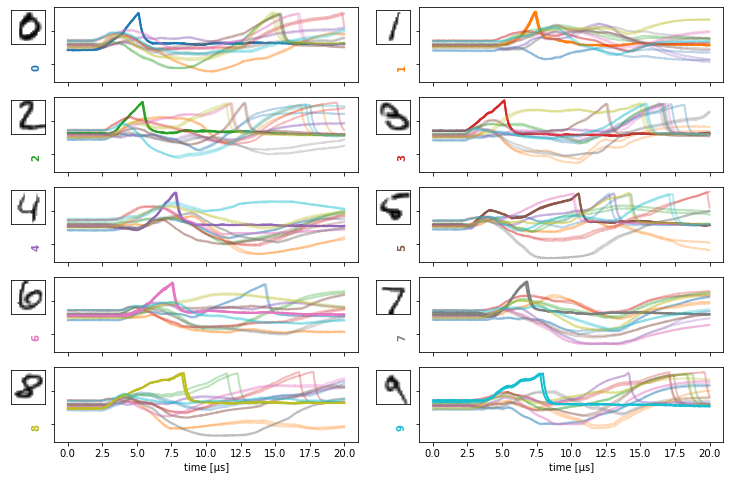

on average 9.0 of 10 samples classified correctly


In [7]:
# set up the plots
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()): 
    ax.set_yticklabels([])
    ax.set_ylabel(f"{distinct_labels[i]}", fontweight='bold')
    ax.yaxis.set_label_coords(-0.04, 0.2)
    ax.yaxis.label.set_color(f"C{distinct_labels[i]}")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("time [μs]")
    
    # preview pic of input
    size = 0.06
    numberClasses = 10
    xl, yl, xh, yh = np.array(ax.get_position()).ravel()
    h = yh - yl
    y_start = yh - 0.035 - size * 0.5  # - 0.92 * h * ((i + 0.5) / numberClasses)
    x_start = xl - size * 0.5 - 0.03  # - 0.05 * ((i + 1) % 2
    ax1 = fig.add_axes([x_start, y_start, size, size])
    # ax1.axison = False
    ax1.imshow(distinct_inputs[i].reshape(16, 16),
               cmap='gray')
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticklabels([])
    ax1.set_yticks([])

corrects = []
# actual recording
for recorded in range(n_classes):
    net.hx_record_neuron = 246 + recorded
    for j in range(n_repetitions):
        for i, ax in enumerate(axes.flatten()):
            outs = net(distinct_inputs[i:i+1])
            corrects.append(outs[0][0].argmin() == distinct_labels[i])
            times, volts = net.trace[:, 0] * 1e6, net.trace[:, 1]
            mask = np.logical_and(times > time_shown[0], times < time_shown[1])
            ax.plot(times[mask], volts[mask], color=f"C{recorded}", lw=2,
                    alpha=1. if distinct_labels[i] == recorded else 0.3)
            # for j, t in enumerate(distinct_inputs[i]):
            #     ax.axvline(t * net.hx_settings["taum"], ymax=0.1, color=f"C{j + 3}")
    clear_output(wait=True)
    display(fig)
clear_output(wait=True)
plt.show()
print(f"on average {np.mean(corrects) * 10} of 10 samples classified correctly")

Example image of the above:
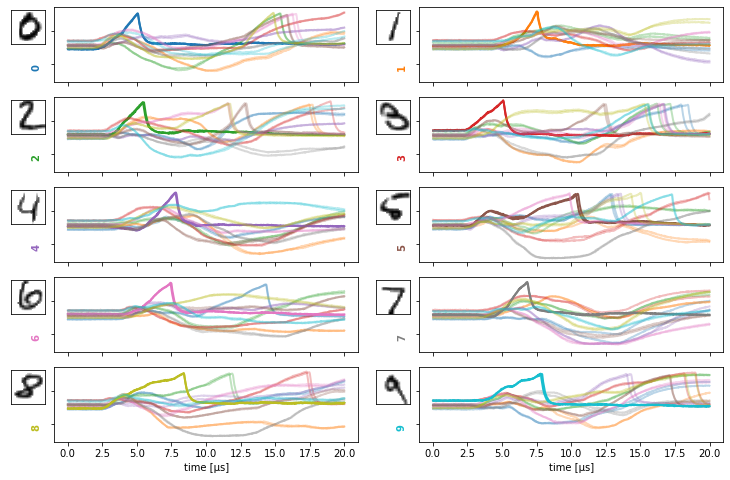